# **Workshop 3**:  Multi-Agent LLMs and Knowledge Graphs for Monitoring and Sustaining Software Systems 




- Presented by *Simeon Tverdal* and *Adela Nedisan Videsjorden* as part of the **International Summer School on LLM-based Agents for Software Engineering**

- LLMA4SE 2025 - **03 September 2025**

- Contact information (and additional questions): simeon.tverdal@sintef.no 🙋‍♂️,  adela.videsjorden@sintef.no 🙋‍♀️

## Part I. Introduction (~30 min)

Welcome to the **Multi-Agent LLMs and Knowledge Graphs for Monitoring and Sustaining Software Systems** workshop! 😺💻

In this workshop, we will explore the synergy between Large Language Models (LLMs), knowledge graphs, and multi-agent systems, demonstrating how their combined integration can advance the software engineering field by identifying, managing, and monitoring technical debt refactoring in AI-generated software artifacts. Our focus will be threefold:

1) **Agents** and **Multi-Agent Systems** enhanced by **Generative AI**:
We will design, build together and demonstrate how specialized GenAI-powered agents can independently but also collaboratively generate code, detect technical debt, refactor and test code, but also continuously monitor technical debt and code evolution, leading to more easily maintainable and reliable software.

2) **Knowledge Graphs** for **Increased Observability and Monitoring**:
We introduce the use of knowledge graphs to track code evolution, which provides a foundation for agentic decision support and addresses the issues of scalability and observability. 

3) Building Smarter Agents with **Agentic Design Patterns** and **Advanced Functionality**: Tips and Tricks
We discuss and show how to apply design patterns to obtain better agent specialization and coordination in agentic systems, but also cover advanced topics such as memory enhancements, retrieval-augmented generation, structured outputs and much more.  

### Session Objectives
Through this hands-on session, participants will not only gain practical experience in leveraging Generative AI and Knowledge Graphs, but also learn how to apply a range of Agentic Design Patterns and added functionality — to build intelligent, interconnected ecosystems of agents. 

This session aims to equip students with powerful tools for identifying, analyzing, and addressing technical debt within modern software systems, showcasing how the synergy between advanced AI techniques and graph-based representations can ultimately improve software quality and sustainability. 

### Inspiration - DYNABIC Project

Our current projects have led way to new approaches of enhancing IoT System observability using a **combination** of **Multi-Agent Systems**, **Large Language Models** and **Knowledge Graphs**.

One such example is *LUMEN*, an analytics module created within a multi-aspect digital twin in the **DYNABIC** project.

**Problem statement**: A *critical infrastructure* can be victim to various cyber attacks. Such infrastructures often consist of many interconnected devices that collect, monitor, and exchange data at an unprecedented scale. As IoT networks grow in size and complexity, the volume and heterogeneity of data they generate pose challenges for the effective management of IoT systems, including monitoring, analysis, and observability. We require intelligent and adaptive techniques that address the diversity of data types and sources, but also the lack of semantic integration.

**Solution**: The target IoT system is modelled as a knowledge graph, capturing the topology of its interconnected devices. The knowledge graph includes special nodes linking to the historical and real-time monitoring data sources of each device, enabling a unified representation of the IoT system. Given a natural language task, collaborating LLM agents perform actions that allow them to interact with the graph content and stored data, and analyze their content by producing on-the-fly code and executing it. 

**Pipeline** - represented in figures below: 



[Figure A] Knowledge Graph Creation

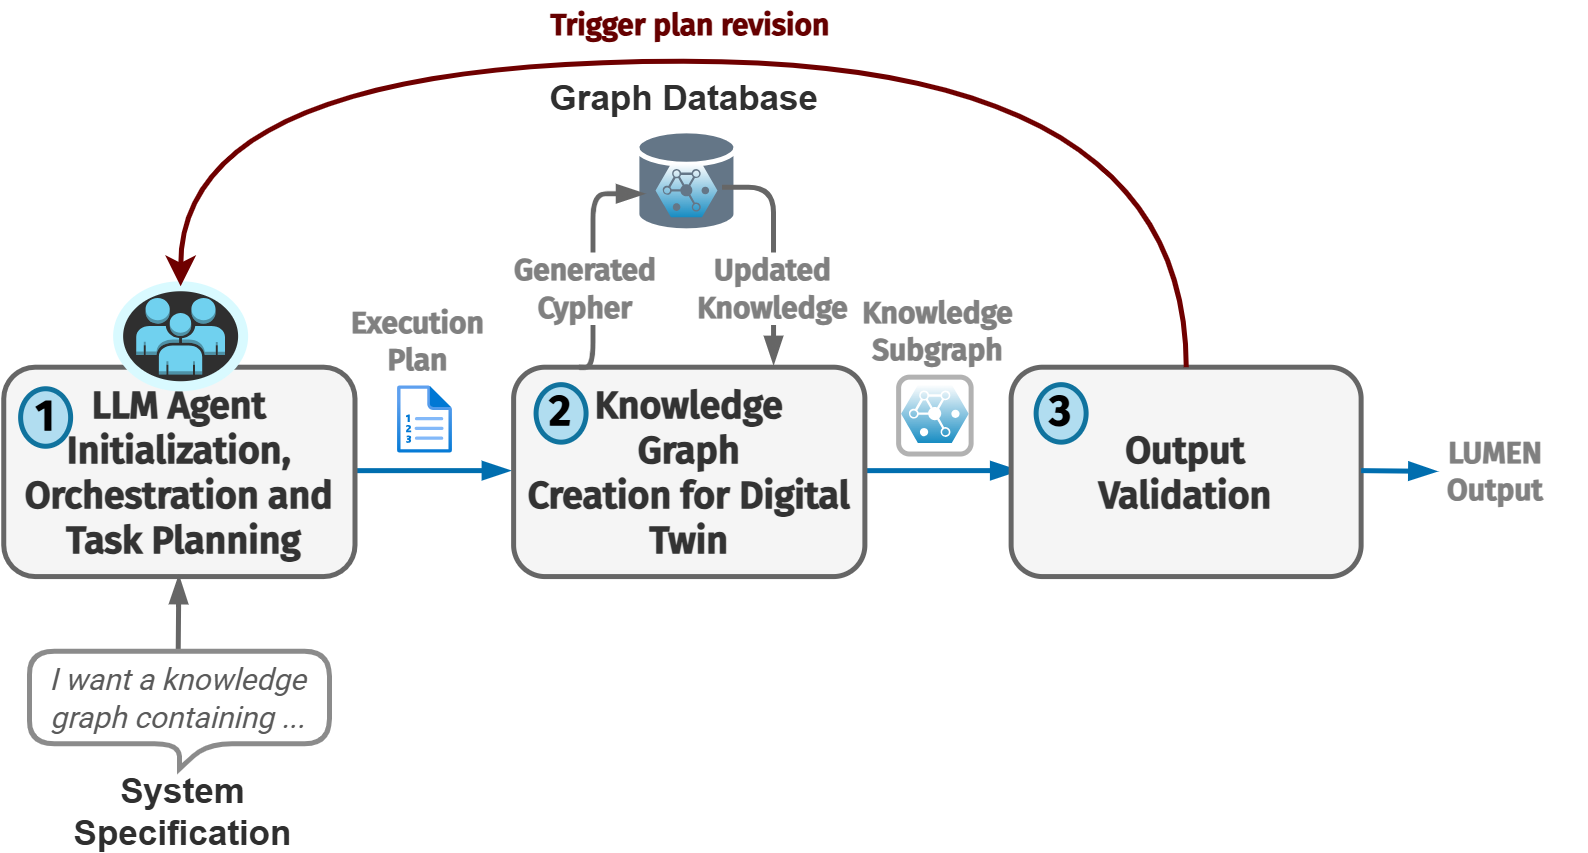

[Figure B] Knowledge Graph Extraction & Data Analysis

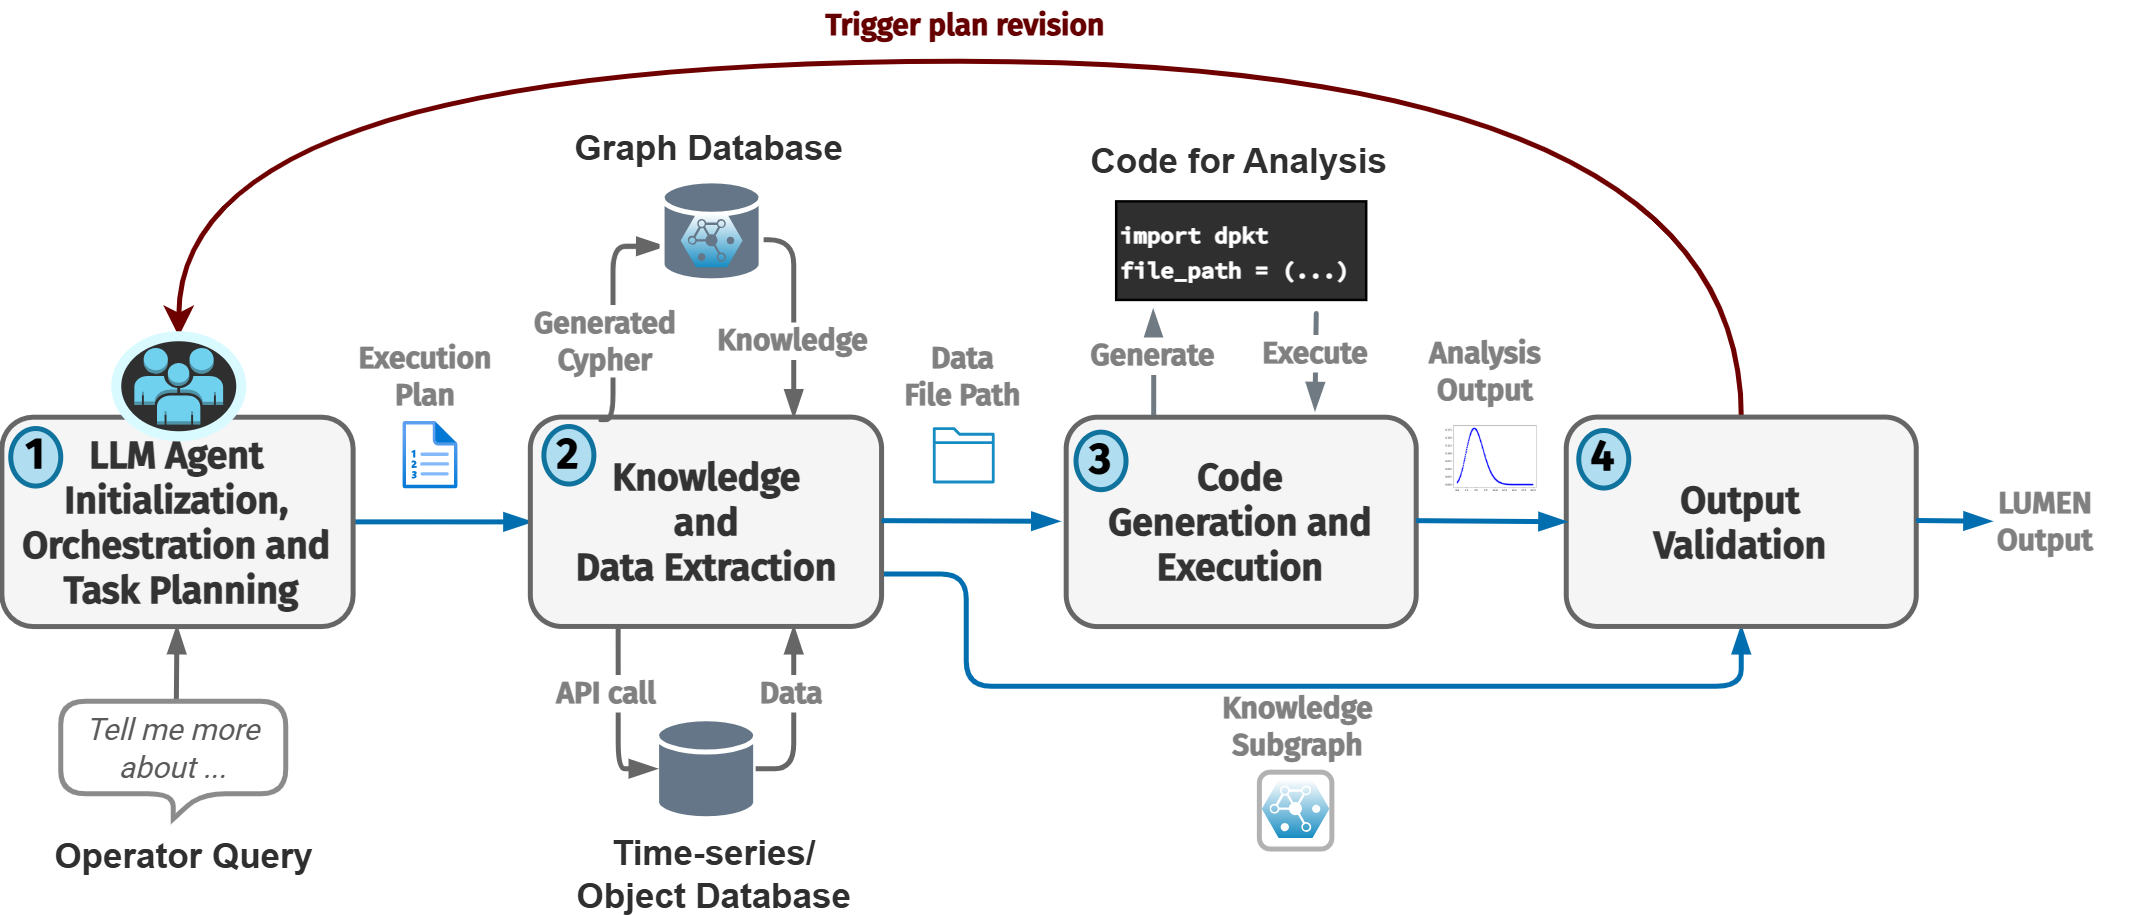

**Agents** - represented in figure below:

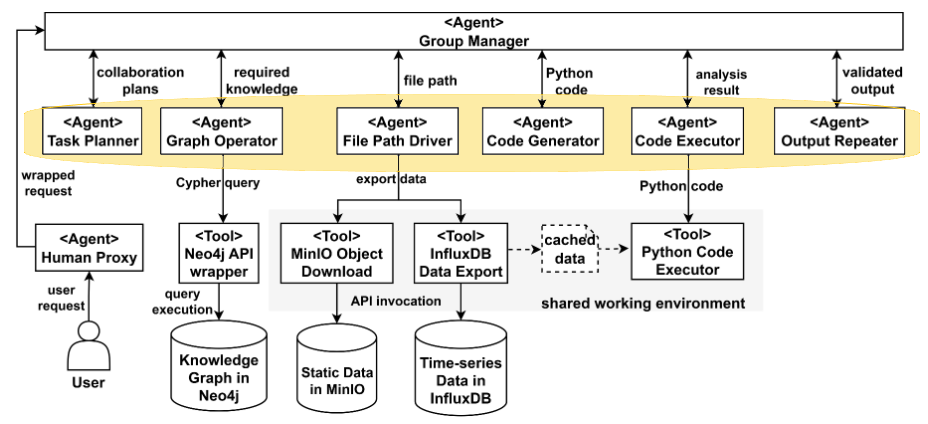

**Some interesting findings**:

- Most responses achieved within 60 seconds.

- 67.7% average success rate (however, very strictly evaluated!).

- Failures mostly stem from ambiguous queries, lack of data metamodels, or misinterpretation during complex task decomposition.

- Over half of the total runs were completed without any self-correction loops, and 79.8% of these were successful on the first attempt!

- Most loops were triggered by the Task Planner and Code Generator agents in response to plan revisions or due to runtime issues.

- Successful outcomes are not achieved at the expense of excessive resource consumption. 



## Motivation

While LUMEN can be described as a helpful assistant, it is indeed negatively affected by its basic implementation.

No structured outputs, no memory, no testing, no well-defined termination criteria ➡️ **A lot of improvement potential**!

We note that Code Generator in particular causes a large portion of the failed runs. As well as in the example above, the reality of AI-generated code is that it can contain technical debt as the model tends to optimize for the immediate prompt. This leads to: hallucinations, vulnerabilities, bugs, shortcuts, poor abstractions, and fragile designs. 

The goal of this hands-on session is to improve the process for code generation, by identifying technical debt, refactoring the code and testing the code. On top of this, we will utilize knowledge graphs for tracking the agent outcomes and code evolution. The resulting knowledge graph can be used for generating various reports, using graph operations. 


Some advantages to using knowledge graphs for monitoring purposes:

- **Traceability** – capture links between code, technical debt items, test outcomes, and more over time.

- **Visualization** – offer a more intuitive view of agent decisions, making evolution patterns easier to spot

- **Interrogability** – use Cypher to explore information stored. Cypher can be easily generated from natural language. 

- **Integration** – combine and link code history with other artifacts such as test outcomes, logs, or even the output of various analysis tools.

**Envisioned Pipeline**:

Even a simplified approach can have multiple designs, each with their own particularities! Two designs will be shown.

Design (A) and Design (B):

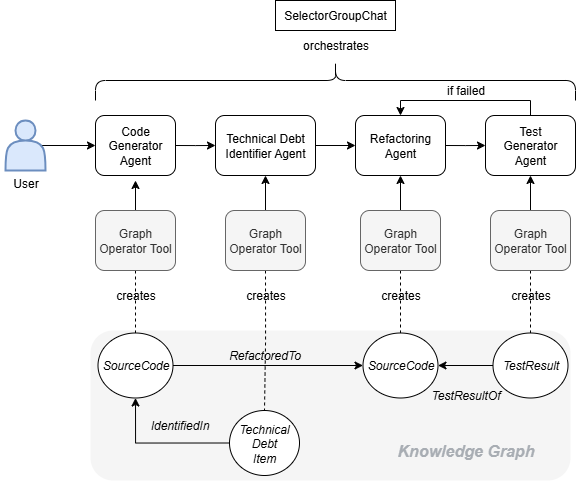 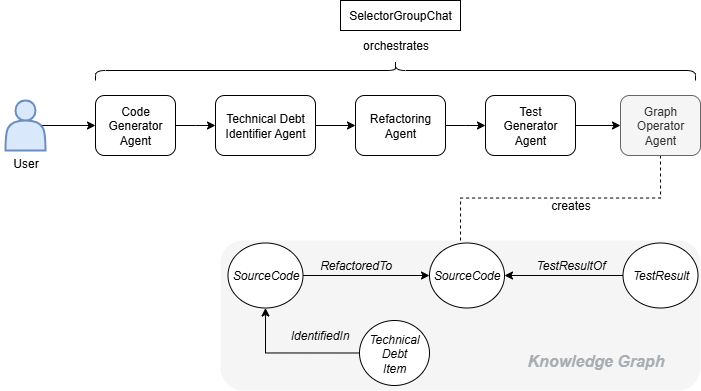

## Part II: Environment Setup (~30 min)
The first step is preparing our environment and experimental setup so everything is installed and made available for the hands-on exercises.

Go to README.md file and follow the guidelines provided!

### Plan:
1. **How to run**: Check README.md on how to run experiments on both cloud and local machine and install necessary packages. 
2. **Import Dependencies and Configure Underlying Model**: Import dependencies and configure Large Language Model. 
3. **Connect to Neo4J and Verify Setup**: Connect to the graph database and test connectivity.


###  Install libraries & packages

In [ ]:
!pip3 install neo4j
!pip3 install -U "autogen-agentchat" "autogen-ext[openai]" "autogen-ext[ollama]" "autogen-ext[chromadb]"
!pip3 install aiohttp
!pip3 install nbclient

### Import relevant libaries

In [2]:
import os
import re
import aiofiles
import aiohttp
import asyncio
import uuid, json
from pathlib import Path
from datetime import datetime
from getpass import getpass
from neo4j import GraphDatabase
from autogen_ext.memory.chromadb import ChromaDBVectorMemory, PersistentChromaDBVectorMemoryConfig
from autogen_agentchat.tools import AgentTool, TeamTool
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.models.ollama import OllamaChatCompletionClient
from autogen_agentchat.conditions import TextMessageTermination, SourceMatchTermination
from autogen_agentchat.agents import AssistantAgent, CodeExecutorAgent
from autogen_ext.code_executors.jupyter import JupyterCodeExecutor
from autogen_ext.tools.code_execution import PythonCodeExecutionTool
from autogen_agentchat.teams import RoundRobinGroupChat, SelectorGroupChat
from autogen_core.model_context import BufferedChatCompletionContext, TokenLimitedChatCompletionContext, ChatCompletionContext
from autogen_core.memory import ListMemory, MemoryContent, MemoryMimeType, Memory
from autogen_agentchat.ui import Console
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage, ModelClientStreamingChunkEvent
from autogen_core.models import UserMessage, CreateResult, SystemMessage, FunctionExecutionResultMessage, FunctionExecutionResult, ChatCompletionClient
from autogen_core.tools import BaseTool, FunctionTool, StaticStreamWorkbench, ToolResult, Workbench
from autogen_agentchat.base import Response
from autogen_agentchat.base import Handoff as HandoffBase
from autogen_core import CancellationToken, Component, ComponentModel, FunctionCall
from pydantic import BaseModel
from typing import List, Optional, Union, Sequence, Any, Callable, Dict, Mapping, AsyncGenerator

###  Prepare the model (Model Configuration)

Note: Colab runs on Google’s cloud VMs, so it does not include local runtimes like Ollama (which is designed to run on your own machine, with local model weights and GPU/CPU).

**[API Model]** OpenAI Model Configuration **(Chosen for workshop)**
  - max_tokens = Maximum number of tokens allowed to generate per response
  - temperature = Controls randomness/creativity of word choice. E.g. 0.0 for deterministic answers, 1.0 for more varied and creative.
  - seed = A fixed number that makes outputs more reproducible.
  - top_p = Nucleus sampling: Another randomness control. E.g. 1.0 (use all options), or 0.9 (only top 90% likely words).

In [3]:
openai_api_key = getpass("Enter the OpenAI API key: ")

In [12]:
openai_model_client = OpenAIChatCompletionClient(
    model = "gpt-4.1",
    api_key = openai_api_key,
    temperature = None,
    max_tokens = 1000,
    seed = None,
    top_p = None,
)

openai_model_client_no_parallel_calls = OpenAIChatCompletionClient(
    model = "gpt-4.1",
    api_key = openai_api_key,
    max_tokens = 1000,
    temperature = None,
    seed = None,
    top_p = None,
    parallel_tool_calls=False,  # Must disable parallel tool calls to avoid concurrency issues in AgentTool/TeamTool
)

# Test model under different configurations and check content of response:
result = await openai_model_client.create([UserMessage(content="What is the capital of Spain?", source="user")])
result.content

'The capital of Spain is **Madrid**.'

**[Local Model]** Ollama Model Configuration

Note: Ollama must be installed on your local machine and the appropriate model pulled. Install: https://ollama.com/download


```
ollama_model_client = OllamaChatCompletionClient(
    model="qwen3:0.6b", # Try out other models!
)

```



### Setup Neo4J Database

[Neo4J](https://neo4j.com/) is a widely-used graph database management system designed to store, manage, and query highly connected data. Unlike traditional relational databases that organize information in tables, Neo4j represents data as **nodes**, **relationships**, and **properties**, making it intuitive for modeling complex domains.

Key characteristics of Neo4j:

- Native graph storage & processing: Optimized for graph data structures, enabling efficient traversal of billions of connections.

- Cypher query language: A declarative query language tailored for working with graph patterns, similar in intent to SQL but optimized for relationships.

- Fully managed (Neo4J AuraDB) or self-managed (Neo4J Graph Database). 

- Ecosystem integration: Offers drivers for major programming languages (Python, Java, JavaScript, etc.), connectors for big data frameworks (Spark, Kafka), and visualization tools like Neo4j Bloom and NeoDash.

**Setting up your Neo4J database:**

In [ ]:
# If you are running the Neo4J aura instance, uncomment the following:

# Fill with the saved password from Neo4J Aura console:
# auradb_password = getpass("Enter your Neo4J Aura password: ")

# Fill with the instance ID from Neo4J Aura console (unsure where? check image below):
# db_id = input("Enter your Aura DB ID (the xxxx part from xxxx.databases.neo4j.io): ")

# Build the full URI
# uri = f"neo4j+s://{db_id}.databases.neo4j.io"

# driver = GraphDatabase.driver(uri, auth=("neo4j", auradb_password))

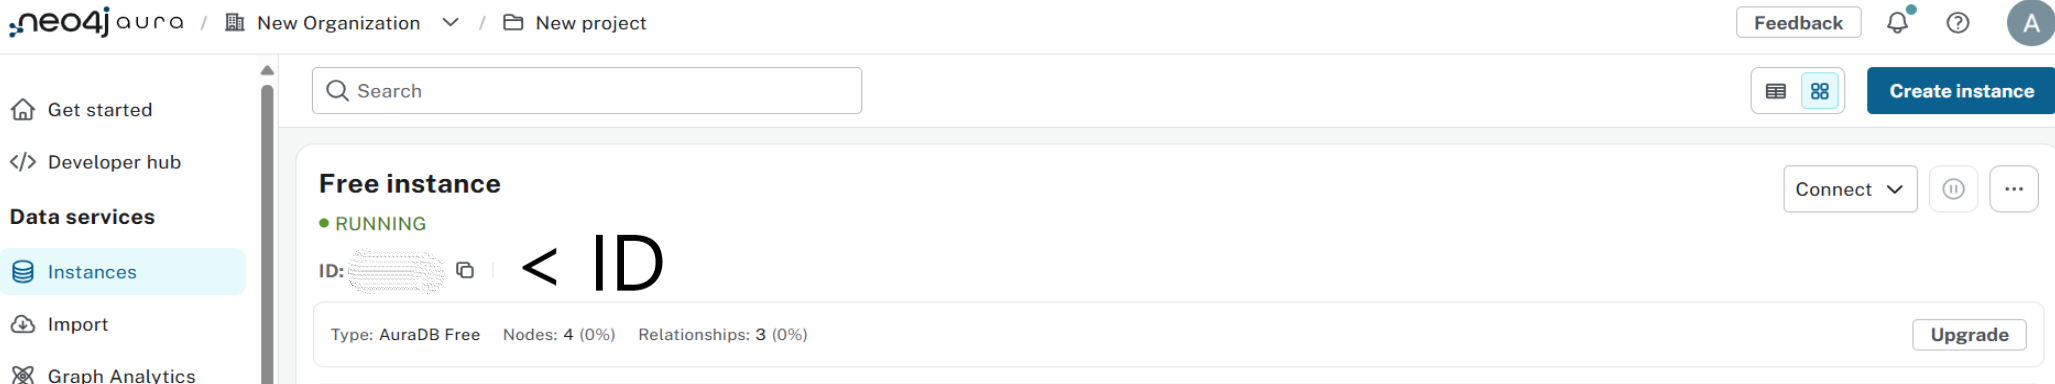

In [ ]:
# If you are running the local Neo4J instance on Docker, uncomment the following:

driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "password"))

In [ ]:
# Connectivity with Neo4J check:
driver.verify_connectivity()

## Part III: Background Foundations: AutoGen, Knowledge Graphs (~30 min)

### Quick Introduction to AutoGen

What do we mean by **agency**, **agent** and **multi-agent system**?

- Agency is the capacity of an actor to make choices and act in accordance with their values in a given environment. 👩‍⚖️

- An agent is an entity empowered to act on behalf of another. Typically an agent acts on behalf of an user with various goals and motivations. A Large Language Model (LLM)-powered agent is an agent that harnesses the capabilities of LLMs (such as reasoning, decision-making, conversing, tool calling). 🗨️👷‍♀️💭

- A multi-agent system consists of two or more agents, interacting with each other. To successfully interact, they need to cooperate, coordinate, and sometimes negotiate, very similar to what people do. This can be replicated by enhancing the agents with the power of LLMs! 💪

### Quick Introduction to AutoGen


**AutoGen** is an open-source programming framework for building LLM-powered **agents** and **multi-agent systems** for task resolution.

It is a fairly popular framework choice in agentic AI research due to its easy-to-use, versatile framework that allows fast creation of applications, being characterized by its high level of customization, enabling developers to program agents using both natural language and programming.

### Quick Introduction to Neo4J and Knowledge Graphs

TODO: Knowledge Graph Introduction

## Part IV. Experimental Setup (~60 min)

### Agent Setup

#### Agentic Tool for Generating Graph Content from Agent Responses

Now, we create a function to run any Cypher query:

In [8]:
async def run_query(query: str) -> str:
    """Run a Cypher query against Neo4j and return results. Returns String representation."""
    try:
        with driver.session() as session:
            result = session.run(query)
            records = [record.data() for record in result]
        return repr(records)
    except Exception as e:
        return repr({"error": str(e)})

In [9]:
# Test running the query:
await run_query("RETURN 'I love Knowledge Graphs!' AS msg")

"[{'msg': 'I love Knowledge Graphs!'}]"

In [10]:
async def get_graph_overview() -> str:
    """Run a Cypher query against Neo4j to get full graph content and return results. Returns String representation."""
    try:
        with driver.session() as session:
            result = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]-(m) RETURN n, r, m")
            records = [record.data() for record in result]
        return repr(records)
    except Exception as e:
        return repr({"error": str(e)})

In [11]:
async def get_latest_node() -> str:
    """Run a Cypher query against Neo4j to get the latest added nodes and return results. Returns String representation."""
    try:
        with driver.session() as session:
            result = session.run("MATCH (n:SourceCode) WITH max(n.timestamp) AS latest MATCH (m) WHERE m.timestamp = latest RETURN m")
            records = [record.data() for record in result]
        return repr(records)
    except Exception as e:
        return repr({"error": str(e)})

In [ ]:
DB_SCHEMA = """  Node Types:
                [SourceCode] with properties:
                - timestamp: datetime              # Current time (format: YYYY-MM-DD HH:MM:SS)
                - code: str                    # The generated code
                - description: str             # Short description of code functionality
                - loc: int                     # Lines of code generated
                - dependencies: List[str]      # Dependencies: e.g. imports, function calls
                - user_prompt: str             # User prompt that led to the code generated
                - time_complexity: str         # Time complexity in Big O notation
                [TechnicalDebtItem] with properties:
                - timestamp: datetime              # Current time (format: YYYY-MM-DD HH:MM:SS)
                - description: List[str]       # Technical Debt Description
                - location: str                # Range of code lines affected
                [TestResult] with properties:
                - timestamp: datetime              # Current time (format: YYYY-MM-DD HH:MM:SS)
                - num_tests: int               # Number of tests generated
                - num_passed_tests: int        # Number of passed tests 
                - num_failed_tests: int        # Number of failed tests
                - tests: str                   # The generated tests
                Relationship Types:
                  (n:SourceCode)-[r:RefactoredTo]->(m:SourceCode)
                  (n:TechnicalDebtItem)-[:IdentifiedIn]->(m:SourceCode) 
                  (n:TestResult)-[:TestResultOf]->(m:SourceCode)"""

In [13]:
# Version 1A : One agent with access to 2 tools (get_graph_overview and run_query) - part of Team.
graph_operator_agent = AssistantAgent(
    name="graph_operator_agent",
    model_client=openai_model_client,
    tools=[get_graph_overview, run_query],
    system_message =f"""Your name is graph_operator_agent. You record agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will track code changes in time, including technical debt items (create one node per item), as identified by other agents.
                    First, you MUST call get_graph_overview to get an overview of the current graph.
                    Second, you MUST use the run_query to capture the agent outputs which are not yet recorded.
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA}""",
    max_tool_iterations = 5,
    reflect_on_tool_use = False,
)

In [14]:
# Version 1B : One agent with access to 2 tools (get_graph_overview and run_query) - part of Team.
graph_operator_agent = AssistantAgent(
    name="graph_operator_agent",
    model_client=openai_model_client,
    tools=[get_latest_node, run_query],
    system_message =f"""Your name is graph_operator_agent. You record agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will track code changes in time, including technical debt items (create one node per item), as identified by other agents.
                    First, you MUST call get_last_node to get the latest SourceCode node added.
                    Second, you MUST use the run_query to capture the agent outputs which are not yet recorded and connect this to the latest SourceCode node.
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA}""",
    max_tool_iterations = 5,
    reflect_on_tool_use = False,
)

In [71]:
test_task = """ Agent 1 has generated the following code:
          def summarize_report(data: List[int]) -> Dict[str, float]:
        if not data:
            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}

        return {
            "count": len(data),
            "sum": calculate_sum(data),
            "mean": statistics.mean(data),
            "median": statistics.median(data),
            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0
        }
        """

await Console(graph_operator_agent.run_stream(task=test_task))

---------- TextMessage (user) ----------
 Agent 1 has generated the following code:
          def summarize_report(data: List[int]) -> Dict[str, float]:
        if not data:
            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}

        return {
            "count": len(data),
            "sum": calculate_sum(data),
            "mean": statistics.mean(data),
            "median": statistics.median(data),
            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0
        }
        
---------- ToolCallRequestEvent (graph_operator_agent) ----------
[FunctionCall(id='call_PCV0fsA8sP3oYiDG9olFwwTk', arguments='{}', name='get_latest_node')]
---------- ToolCallExecutionEvent (graph_operator_agent) ----------
[FunctionExecutionResult(content='[]', name='get_latest_node', call_id='call_PCV0fsA8sP3oYiDG9olFwwTk', is_error=False)]
---------- ToolCallRequestEvent (graph_operator_agent) ----------
[FunctionCall(id='call_4CdUBbVFaQJvArQn5d6Gttar', argument

TaskResult(messages=[TextMessage(id='ad2cad6c-a4c3-415a-afc0-de0752168d4a', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 1, 17, 28, 1, 423505, tzinfo=datetime.timezone.utc), content=' Agent 1 has generated the following code:\n          def summarize_report(data: List[int]) -> Dict[str, float]:\n        if not data:\n            return {"count": 0, "sum": 0, "mean": None, "median": None, "stdev": None}\n\n        return {\n            "count": len(data),\n            "sum": calculate_sum(data),\n            "mean": statistics.mean(data),\n            "median": statistics.median(data),\n            "stdev": statistics.stdev(data) if len(data) > 1 else 0.0\n        }\n        ', type='TextMessage'), ToolCallRequestEvent(id='ec291c2c-82fe-479c-8f75-74ce3d496614', source='graph_operator_agent', models_usage=RequestUsage(prompt_tokens=631, completion_tokens=11), metadata={}, created_at=datetime.datetime(2025, 9, 1, 17, 28, 2, 596055, tzinfo=datetime.t

In [13]:
class ForcedAssistantAgent(AssistantAgent):
    """AssistantAgent that always enforces tool calling."""

    @classmethod
    async def _call_llm(
        cls,
        model_client: ChatCompletionClient,
        model_client_stream: bool,
        system_messages: List[SystemMessage],
        model_context: ChatCompletionContext,
        workbench: Sequence[Workbench],
        handoff_tools: List[BaseTool[Any, Any]],
        agent_name: str,
        cancellation_token: CancellationToken,
        output_content_type: type[BaseModel] | None,
        message_id: str,
    ) -> AsyncGenerator[Union[CreateResult, ModelClientStreamingChunkEvent], None]:
        """Call the language model with given context and configuration.

        Args:
            model_client: Client for model inference
            model_client_stream: Whether to stream responses
            system_messages: System messages to include
            model_context: Context containing message history
            workbench: Available workbenches
            handoff_tools: Tools for handling handoffs
            agent_name: Name of the agent
            cancellation_token: Token for cancelling operation
            output_content_type: Optional type for structured output

        Returns:
            Generator yielding model results or streaming chunks
        """
        all_messages = await model_context.get_messages()
        llm_messages = cls._get_compatible_context(model_client=model_client, messages=system_messages + all_messages)

        tools = [tool for wb in workbench for tool in await wb.list_tools()] + handoff_tools

        if model_client_stream:
            model_result: Optional[CreateResult] = None

            async for chunk in model_client.create_stream(
                llm_messages,
                tools=tools,
                tool_choice="required",   # Needs to be added to enforce tool call!
                json_output=output_content_type,
                cancellation_token=cancellation_token,
            ):
                if isinstance(chunk, CreateResult):
                    model_result = chunk
                elif isinstance(chunk, str):
                    yield ModelClientStreamingChunkEvent(content=chunk, source=agent_name, full_message_id=message_id)
                else:
                    raise RuntimeError(f"Invalid chunk type: {type(chunk)}")
            if model_result is None:
                raise RuntimeError("No final model result in streaming mode.")
            yield model_result
        else:
            model_result = await model_client.create(
                llm_messages,
                tools=tools,
                tool_choice="required", # Needs to be added to enforce tool call!
                cancellation_token=cancellation_token,
                json_output=output_content_type,
            )
            yield model_result



In [ ]:
# Version 2A:  Wrapping Team as Tool (via TeamTool) - Added as tool in Team members
# Note: all agents using this tool must change model config to openai_model_client_no_parallel_calls
graph_overview_agent = ForcedAssistantAgent(
    name = "graph_overview_agent",
    model_client = openai_model_client,
    tools = [get_graph_overview],
    system_message = " You MUST use the get_graph_overview tool to provide the graph content. ",
    model_context = BufferedChatCompletionContext(buffer_size=1),  # Does not need any context (save resources)
    reflect_on_tool_use = False
)

async def get_current_date() -> str:
    """Returns current datetime in string representation."""
    return str(datetime.now())


datetime_agent = ForcedAssistantAgent(
    name = "datetime_agent",
    model_client = openai_model_client,
    tools = [get_current_date],
    system_message = " You MUST use the get_current_date tool to provide the current date. ",
    model_context = BufferedChatCompletionContext(buffer_size=1),  # Does not need any context (save resources)
    reflect_on_tool_use = False
)

graph_operator_agent = AssistantAgent(
    name = "graph_operator_agent",
    model_client = openai_model_client,
    tools = [run_query],
    system_message = f""" You record agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will record code changes in time, with eventual technical debt items and test results, as identified by other agents.
                    You MUST use the run_query to capture the agent outputs which are not yet recorded (current datetime and overview of current graph is provided).
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA} """,
    max_tool_iterations = 5,
    reflect_on_tool_use = False
)

graph_operating_team = RoundRobinGroupChat(
        [datetime_agent, graph_overview_agent, graph_operator_agent], termination_condition=SourceMatchTermination(sources=["graph_operator_agent"])
)

# Create a TeamTool that uses the team to run tasks, returning the last message as the result.
graph_tool = TeamTool(
        team=graph_operating_team,
        name="graph_operating_team",
        description="A tool for translating agent outputs to graph format.",
        return_value_as_last_message=True,
)

NameError: name 'ForcedAssistantAgent' is not defined

In [24]:
# Version 2B:  Wrapping Team as Tool (via TeamTool) - Added as tool in Team members
# Note: all agents using this tool must change model config to openai_model_client_no_parallel_calls
last_node_agent = ForcedAssistantAgent(
    name = "last_node_agent",
    model_client = openai_model_client,
    tools = [get_latest_node],
    system_message = " You MUST use the get_latest_node tool to provide the latest SourceCode node. ",
    model_context = BufferedChatCompletionContext(buffer_size=1),  # Does not need any context (save resources)
    reflect_on_tool_use = False
)

async def get_current_date() -> str:
    """Returns current datetime in string representation."""
    return str(datetime.now())


datetime_agent = ForcedAssistantAgent(
    name = "datetime_agent",
    model_client = openai_model_client,
    tools = [get_current_date],
    system_message = " You MUST use the get_current_date tool to provide the current date. ",
    model_context = BufferedChatCompletionContext(buffer_size=1),  # Does not need any context (save resources)
    reflect_on_tool_use = False
)

graph_operator_agent = AssistantAgent(
    name = "graph_operator_agent",
    model_client = openai_model_client,
    tools = [run_query],
    system_message = f"""You record previous agent outputs into a graph by generating **Cypher queries**.
                    Context: The graph will record code changes in time, with eventual technical debt items and test results, as identified by other agents.
                    You MUST use the run_query to capture the agent outputs which are not yet recorded (current datetime and the last added SourceCode node, if any, is provided).
                    Rules:
                    1) Only one Cypher statement per query is allowed.
                    2) You MUST follow the schema: {DB_SCHEMA} """,
    max_tool_iterations = 5,
    reflect_on_tool_use = False,
    model_context = BufferedChatCompletionContext(buffer_size=3)
)

graph_operating_team = RoundRobinGroupChat(
        [datetime_agent, last_node_agent, graph_operator_agent], termination_condition=SourceMatchTermination(sources=["graph_operator_agent"])
)

# Create a TeamTool that uses the team to run tasks, returning the last message as the result.
graph_tool = TeamTool(
        team=graph_operating_team,
        name="graph_operating_team",
        description="A tool for translating agent outputs to graph format.",
        return_value_as_last_message=True,
)

#### Agent Specialized in Generating Python Code from User Request

Exercises:
- Can you improve the default description and system_message:  [DEFAULT_AGENT_DESCRIPTION](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent.DEFAULT_AGENT_DESCRIPTION) and [DEFAULT_SYSTEM_MESSAGE](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent.DEFAULT_SYSTEM_MESSAGE)?
- Test with more complex programming tasks. What limitations can you identify?
- Check the documentation of the [CodeExecutorAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.CodeExecutorAgent). What other parameters can we set to achieve a more efficient agent?

In [18]:
# Agent that generates code
code_generator_agent = AssistantAgent("code_generator_agent",
                                      model_client = openai_model_client,
                                      system_message = """Your name is code_generator_agent. Your role is to generate Python code given instructions.
                                                          Provide Python code in ```python code blocks.""")

In [25]:
# Agent that generates code (monitored version)
monitored_code_generator_agent = AssistantAgent("code_generator_agent",
                                      model_client = openai_model_client_no_parallel_calls,
                                      tools=[graph_tool],
                                      system_message = """Your name is code_generator_agent. Generate Python code given instructions, then call the graph_tool (always!).
                                                          Provide Python code in ```python code blocks.
                                                          Remember to call the graph_tool to capture the generated code in graph format. """,
                                      reflect_on_tool_use = False
                                      )

In [20]:
# Test:
test_task = "Write Python code that prints Hello, Portugal!"

await Console(monitored_code_generator_agent.run_stream(task=test_task))

---------- TextMessage (user) ----------
Write Python code that prints Hello, Portugal!
---------- ToolCallRequestEvent (code_generator_agent) ----------
[FunctionCall(id='call_w3upG33iRcHowUlFk6dxJC5d', arguments='{"task":"Write Python code that prints \'Hello, Portugal!\'"}', name='graph_operating_team')]
---------- TextMessage (user) ----------
Write Python code that prints 'Hello, Portugal!'
---------- ToolCallRequestEvent (datetime_agent) ----------
[FunctionCall(id='call_pIdN7MV1wA036c1gki7ofTex', arguments='{}', name='get_current_date')]
---------- ToolCallExecutionEvent (datetime_agent) ----------
[FunctionExecutionResult(content='2025-09-01 20:18:32.267612', name='get_current_date', call_id='call_pIdN7MV1wA036c1gki7ofTex', is_error=False)]
---------- ToolCallSummaryMessage (datetime_agent) ----------
2025-09-01 20:18:32.267612
---------- ToolCallRequestEvent (last_node_agent) ----------
[FunctionCall(id='call_UYykYKmZ84ufz9pbSNJ72Wq2', arguments='{}', name='get_latest_node')]


TaskResult(messages=[TextMessage(id='91e5fdf8-7c9b-45a0-860e-5e517ec5966e', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 1, 18, 18, 29, 120110, tzinfo=datetime.timezone.utc), content='Write Python code that prints Hello, Portugal!', type='TextMessage'), ToolCallRequestEvent(id='75778048-74c7-4f28-861b-d577b2f628ce', source='code_generator_agent', models_usage=RequestUsage(prompt_tokens=111, completion_tokens=25), metadata={}, created_at=datetime.datetime(2025, 9, 1, 18, 18, 31, 72164, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_w3upG33iRcHowUlFk6dxJC5d', arguments='{"task":"Write Python code that prints \'Hello, Portugal!\'"}', name='graph_operating_team')], type='ToolCallRequestEvent'), TextMessage(id='47560342-95dc-46dc-b442-753255199e3e', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 1, 18, 18, 31, 72164, tzinfo=datetime.timezone.utc), content="Write Python code that prints 'Hello, Portu

####  Agent Specialized in Technical Debt Detection (with Memory)

This agent is responsible for identifying technical debt in code. It will recieve a prompt consisting of a description of technical debt alongside the code to analyse and output a response containing the type, location and description of technical debt.

To improve performance we can include a list of technical debt items to look for, improving precision of non-technical llms by providing a description of each type. In addition, we can use a one shot or zero shot prompt by including examples of each type we want to look for.

How can this be improved?
  - Does the average LLM contain enough information about technical debt to accurately identify Technical debt items?
  - Would we see improvement by using a code focused LLM?
  - How could we utilize techniques such as RAG to improve this implementation?

In [27]:
# Structure the output - expected format:
class LocationRange(BaseModel):
    """Represents a code location as a line range (inclusive)."""
    start_line: int
    end_line: int

class TDIdentifierStructuredOutput(BaseModel):
    """
    Structured output for identified technical debt.
    Notes:
        - `technical_debt_types`, `descriptions`, and `locations`
          MUST always have the same length.
    """
    technical_debt_types: List[str] | None
    descriptions: List[str] | None
    location: List[LocationRange] | None

In [28]:
# Initialize memory of the agent:
tdidentifier_memory = ListMemory()

In [29]:
await tdidentifier_memory.add(MemoryContent(content="""[Duplicated code blocks] It refers to instances where the same or very similar code blocks
                                     appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the
                                     logic would need to be replicated across all instances to maintain consistency. It also increases the codebase size
                                     unnecessarily and can lead to bugs if the copies diverge over time.""", mime_type=MemoryMimeType.TEXT))

In [30]:
await tdidentifier_memory.add(MemoryContent(content="""[Nested flow statements] It refers to situations where control structures like loops or conditional
                                    statements (e.g., for, while, if-else) are placed within one another, often to several levels of depth. This nesting
                                    can lead to code that is difficult to read, understand, and maintain. It can make debugging challenging and increase the
                                     risk of errors, as understanding the logic flow becomes more complex with each added level.""", mime_type=MemoryMimeType.TEXT))

In [31]:
await tdidentifier_memory.add(MemoryContent(content=""" [Long method/Complex Class] It refers to methods or classes in software that are overly long or complex.
                                                  A method contains too many lines of code, or a class has too many responsibilities, violating principles like
                                                   Single Responsibility and leading to code that's hard to understand, maintain, and test. Such methods or
                                                    classes often encapsulate multiple functionalities, making them prone to bugs and difficult to modify. """, mime_type=MemoryMimeType.TEXT))

In [32]:
# Agent that identifies technical debt
td_identifier_agent = AssistantAgent(
    name = "technical_debt_identifier",
    model_client = openai_model_client,
    system_message = """Your name is technical_debt_identifier.
                      Your role is to identify technical and architectural debt in the provided code.""",
    output_content_type = TDIdentifierStructuredOutput,
    memory=[tdidentifier_memory]
)

In [33]:
# Agent that identifies technical debt (monitored version)
monitored_td_identifier_agent = AssistantAgent(
    name = "technical_debt_identifier",
    model_client = openai_model_client_no_parallel_calls,
    system_message = """Your name is technical_debt_identifier.
                      Your role is to identify technical and architectural debt in the provided code, then call the graph_tool (always!).
                      Remember to call the graph_tool to capture the identified technical debt in graph format. """,
    memory = [tdidentifier_memory],
    reflect_on_tool_use = False,
    tools = [graph_tool],
)

In [46]:
code_content = """
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys
"""

technical_debt_item = await Console(monitored_td_identifier_agent.run_stream(task=f"Generated code: {code_content}"))

---------- TextMessage (user) ----------
Generated code: 
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys

---------- MemoryQueryEvent (technical_debt_identifier) ----------
[MemoryContent(content='[Duplicated code blocks] It refers to instances where the same or very similar code blocks\n                                     appear in multiple locations within a software project. It can lead to maintenance challenges, as any change to the\n                                     logic would need to be replicated across all instances to maintain consistency. It also increases the codebase size\n                                     unnecessarily and can lead to bugs if the copies diverge over time.', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None), MemoryContent(content='[Nested flow statements] It refers to situations where control structures like l

Examples of items that could be vectorized for rag include scientific articles, websites containing enumerations and textual definitions and examples.


Articles:
https://www.sciencedirect.com/science/article/pii/S0950584915001743

#### Agent Specialized in Performing Technical Debt Refactoring

This agent is responsible for providing suggestions on how to resolve the technical debt. In cases where the technical debt item is more complex, say it involves multiple files, giving the refactoring agent a suggestion as input in addition to the code can improve results. Examples of these types of technical debt items are cyclic dependencies involving several files or modules.

This agent takes as input the code, in addition to the types, locations and descriptions of the previously identified technical debt items.

What types of technical debt items comes to mind when we think of higher complexity?

This agent focuses on refactoring recieved code. It takes as input the output of all previous agents, this being code, identified technical debt with description and location, as well as a suggestion for how to refactor the code. The output is the refactored code.

To improve this agent we can decide to use an LLM specialized in writing code.

What should be considered with this agent?
  - How can we ensure that the output of this agent is properly formatted?
      - Prompt engineering?
      - Preloading?
      - External guard rails?

In [34]:
class StructuredRefactorOutput(BaseModel):
    description: str            # Description of the fix
    refactored_code: str        # Refactored code

In [30]:
# Refactoring agent Version 1 : Takes the code and refactors it according to technical debt items
refactoring_agent = AssistantAgent(
    name="refactoring_agent",
    model_client=openai_model_client,
    system_message="Your name is refactoring_agent. Your role is to refactor the provided code based on the identified technical debt items.",
    output_content_type=StructuredRefactorOutput,
)

In [35]:
# Refactoring agent Version 1 : Takes the code and refactors it according to technical debt items
monitored_refactoring_agent = AssistantAgent(
    name="refactoring_agent",
    model_client=openai_model_client_no_parallel_calls,
    tools=[graph_tool],
    system_message="""Your name is refactoring_agent. Your role is to refactor the provided code based on the identified technical debt items and document the results by
                     calling graph_tool. Remember to call the graph_tool to capture the refactored code in graph format. """,
    max_tool_iterations = 5,
)

In [ ]:
await Console(monitored_refactoring_agent.run_stream(task=f"""Refactor this code,:\n\n{code_content} to fix this technical debt item \n\n{technical_debt_item}. 
                                                     Provide both the description and the full code."""))

---------- TextMessage (user) ----------
Refactor this code,:


def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys
 to fix this technical debt item 

messages=[TextMessage(id='63e7a445-ab3f-44f9-9fdd-f8d09c71bef1', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 1, 17, 1, 4, 815412, tzinfo=datetime.timezone.utc), content="Generated code: \ndef calculate_total(items):\n    total = 0\n    for item in items:\n        total += item['price'] * item['quantity']\n    return total\n\n# TODO: Add error handling for missing keys\n", type='TextMessage'), MemoryQueryEvent(id='43ebeaae-6ce0-458a-8e9f-05810664c346', source='technical_debt_identifier', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 9, 1, 17, 1, 4, 819252, tzinfo=datetime.timezone.utc), content=[MemoryContent(content='[Duplicated code blocks] It refers to

RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4.1 in organization org-jLgLE5Zs7NNMiAjlQDMYodOg on tokens per min (TPM): Limit 30000, Requested 63555. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

#### *(Optional)* Agent Specialized in Performing Tests

This agent will receive the refactored code created by the previous agents. Other possibilites include performing static analysis of the code by using tool calls in the testing agent.

Tasks:

 - Modify the prompt to Improve the output.
    - How concise is the default response?
    - Does it contain unneccessary information?
    - Remember that the test output should be read by both humans and LLMs.

  - Are there other modifications you could make to improve the agent?
    - Output format?
    - Hyperparameters?
      - How much temperature would we want in this case?

In [32]:
# Code Generator Version 1 : Generates tests and executes them

jupyter_test_executor = JupyterCodeExecutor() # Code executor class, using nbclient
# Agent that generates and executes tests 
test_generator_agent = CodeExecutorAgent(
  name = "test_generator_agent",
  code_executor = jupyter_test_executor,
  model_client = openai_model_client,
  system_message = """Your name is test_generator_agent. You generate regression/unit tests, add them to the end of the code, make them executable by calling main(), and execute the code."""
)

In [36]:
# Code Generator Version 2 : Generates tests, executes, and is monitored.

jupyter_test_executor = JupyterCodeExecutor() # Code executor class, using nbclient
execute_code = PythonCodeExecutionTool(jupyter_test_executor) # Tool that executes Python code 
# Agent that generates and executes tests (monitored version)
monitored_test_generator_agent = AssistantAgent("test_generator_agent",
                                      model_client = openai_model_client_no_parallel_calls,
                                      tools=[execute_code, graph_tool],
                                      system_message = """Your name is test_generator_agent. You generate regression and unit tests, add them to the end of the code, make them executable by calling main(), execute the code, then call the graph_tool (always!):
                                                          Remember to always call graph_tool to capture the test outcome in graph format. """,
                                      max_tool_iterations = 5,

)

In [79]:
# Test:
test_task = """[Refactored code]: class DiscountPolicy:
    def __init__(self, vip_rate=0.20, regular_rate=0.10):
        self.vip_rate = vip_rate
        self.regular_rate = regular_rate

    def get_discount_rate(self, customer):
        return self.vip_rate if customer.get("is_vip", False) else self.regular_rate


class OrderCalculator:
    def __init__(self, discount_policy=None):
        self.discount_policy = discount_policy or DiscountPolicy()

    def calculate_total(self, order, customer):
        subtotal = sum(item["price"] * item["quantity"] for item in order)
        discount_rate = self.discount_policy.get_discount_rate(customer)
        return subtotal * (1 - discount_rate)"""

await jupyter_test_executor.start()
await Console(monitored_test_generator_agent.run_stream(task=test_task))
await jupyter_test_executor.stop()

---------- TextMessage (user) ----------
[Refactored code]: class DiscountPolicy:
    def __init__(self, vip_rate=0.20, regular_rate=0.10):
        self.vip_rate = vip_rate
        self.regular_rate = regular_rate

    def get_discount_rate(self, customer):
        return self.vip_rate if customer.get("is_vip", False) else self.regular_rate


class OrderCalculator:
    def __init__(self, discount_policy=None):
        self.discount_policy = discount_policy or DiscountPolicy()

    def calculate_total(self, order, customer):
        subtotal = sum(item["price"] * item["quantity"] for item in order)
        discount_rate = self.discount_policy.get_discount_rate(customer)
        return subtotal * (1 - discount_rate)
---------- ToolCallRequestEvent (test_generator_agent) ----------
[FunctionCall(id='call_giM3ydLePddWTkrpgR2nqB8H', arguments='{"code":"# Add tests for DiscountPolicy and OrderCalculator and execute them.\\nimport math\\n\\nclass DiscountPolicy:\\n    def __init__(self, vip_r

#### Termination Agent

### Team Setup

Now we can create a selector group chat, to allow for more complex interactions between agents.

Here, a selector agent will be created to allow for the code to be analysed until it has passed a test. The selector will make a choice depending on the output of th test agent, and will either pass the refactored code further or make the refactoring agent attempt another refactoring with further information from the test agent.

The selector agent is a higher level API from the autogen library, and we could have implemented similar functionality by using other parts of the framework for a more custom solution.
  - What would you change from this approach?
  - What are the possible areas where the groupchat could fail?
      - How would temperature affect the chat?
  - In this example we use a candidate function to follow a predetermined flow. Would a less deterministic selection prompt be beneficial? Would a high or low temperature be most beneficial for this?

In [ ]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from typing import List, Sequence
#from autogen_agentchat import GroupChatManager


text_mention_termination = TextMentionTermination("TERMINATE")
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination

#model_client = OllamaChatCompletionClient(model="qwen3:0.6b")
model_client = openai_model_client


planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=model_client,
    system_message="""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
      : Identifies technical debt
      Technical_debt_refactoring_suggestor: Creates suggestions for fixing identified technical debt
      Technical_debt_refactoring_agent: Refactors code based on suggestions from the suggestor agent or feedback from the test agent
      Test_agent: Analyses refactored code and decides whether or not it is approved.


    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>

    After all tasks are complete, summarize the findings and end with "TERMINATE".
    """,
)

selector_prompt = """You are coordinating a multi-agent workflow focused on identifying and resolving technical debt.

Agent roles:
{roles}

Conversation history:
{history}

Based on the above context, select the most appropriate agent from {participants} to perform the next step in the workflow.

Important:
- Ensure that the Technical_debt_identifier has initiated the process before others proceed.
- Follow the logical sequence: identification → suggestion → refactoring → testing → approval.
- Only one agent should be selected at a time.

Choose the agent best positioned to advance the current task.
"""

# Create the group chat
team = SelectorGroupChat(
    [planning_agent, td_identifier_agent, refactoring_agent, test_agent],
    model_client=model_client,
    selector_prompt=selector_prompt,  # Default model-based selector,
    allow_repeated_speaker=True,
    termination_condition=termination
)
task = f"Analyze the following code and identify technical debt:\n\n{code_content}. Then suggest a refactoring strategy and refactor the code."
await jupyter_test_executor.start()
await Console(team.run_stream(task=task))
await jupyter_test_executor.stop()

#manager = GroupChatManager(groupchat=group_chat)

# Entry point
#user_proxy = UserProxyAgent(name="User", code_execution_config=False)

# Start the chat
#user_proxy.initiate_chat(
#    manager,
#    message="Here's a piece of code. Can you help me review and improve it?"
#)

The above is one of the more basic ways of running a system of agents. In many cases however, and in this example, it makes more sense to be more deterministic in which agent we choose. We expect a regular pattern to the order of the agents, something that can not be appropriately enforced with a selector agent. In this case we can choose to write an algorithm to select the next agent based on both the preceding agent and the response they gave. Below we have a simple candidate function which determines the next agent in the order. Each agent is called in sequential order, until we evaluate the response from the test agent. If it approves we are done and thus terminate. If not, we go back to the refactoring agent and try again.

What are the benefits and detriments of this approach?
    - Are we likely to need the flexibility of the group chat manager?
    - In which scenarios would you expect the group chat manager to be useful?
    - How would you improve the candidate function used in this example?

Now we add the code generator.

In [ ]:
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination, HandoffTermination, FunctionalTermination
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage
from typing import List, Sequence
from autogen_agentchat.messages import StructuredMessage

def expression(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> bool:
    last_msg = messages[-1]
    if last_msg.source == "test_generator_agent":
        with driver.session() as session:
            result = session.run("""
                MATCH (n:TestResult)
                WITH max(n.timestamp) AS latest
                MATCH (m:TestResult)
                WHERE m.timestamp = latest
                RETURN m.num_failed_tests AS num_failed_tests
            """)
            record = result.single()
            if record is None:
                return True
            num_failed = record["num_failed_tests"]
            return num_failed == 0
    # if source isn’t test_generator_agent, continue:
    return False

text_mention_termination = TextMentionTermination("TERMINATE")
functional_termination = FunctionalTermination(expression)
max_messages_termination = MaxMessageTermination(max_messages=25)
termination = text_mention_termination | max_messages_termination | functional_termination

# Candidate function to narrow down eligible agents
def candidate_func(messages: Sequence[BaseAgentEvent | BaseChatMessage]) -> List[str]:
    last_msg = messages[-1]
    last_sender = messages[-1].source
    #if isinstance(last_msg, ToolCallSummaryMessage):
    #    return [last_sender]
    if last_sender == "user":
        return [monitored_code_generator_agent.name]
    if last_sender == "code_generator_agent":
        return [monitored_td_identifier_agent.name]
    if last_sender == "technical_debt_identifier":
        return [monitored_refactoring_agent.name]
    elif last_sender == "refactoring_agent":
        return [monitored_test_generator_agent.name]
    elif last_sender == "test_generator_agent":
        #print("-------------------> last msg",last_msg)
        #if "APPROVED" in last_msg or "looks good" in last_msg or "passed" in last_msg:
        #    return "user"  # Terminate
        #else:
        return [monitored_refactoring_agent.name]  # Loop back for improvements
    return []  # Default fallback

def candidate_func_adapter(thread) -> List[AssistantAgent]:
    print(thread)
    return candidate_func(thread.messages, thread.agents)

# Create the group chat
team = SelectorGroupChat(
    [monitored_code_generator_agent, monitored_td_identifier_agent, monitored_refactoring_agent, monitored_test_generator_agent],
    model_client=openai_model_client,
    termination_condition=termination,
    candidate_func=candidate_func,
)

task = f"Generate a piece of code that checks if the sum of two numbers is over 100. If it's over 100, it prints This is a high number, otherwise it prints This is a low number"
await team.reset()
await jupyter_test_executor.start()
await Console(team.run_stream(task=task))
await jupyter_test_executor.stop()
await team.reset()


---------- TextMessage (user) ----------
Generate a piece of code that checks if the sum of two numbers is over 100. If it's over 100, it prints This is a high number, otherwise it prints This is a low number
---------- ToolCallRequestEvent (code_generator_agent) ----------
[FunctionCall(id='call_r9KJt2eeTZhcTNoFesfKP9IT', arguments='{"task":"Check if the sum of two numbers is over 100, print a high or low number message accordingly."}', name='graph_operating_team')]
---------- TextMessage (user) ----------
Check if the sum of two numbers is over 100, print a high or low number message accordingly.
---------- ToolCallRequestEvent (datetime_agent) ----------
[FunctionCall(id='call_wefxLGE8ObPJWQPvvba4M6kw', arguments='{}', name='get_current_date')]
---------- ToolCallExecutionEvent (datetime_agent) ----------
[FunctionExecutionResult(content='2025-09-01 21:06:09.408774', name='get_current_date', call_id='call_wefxLGE8ObPJWQPvvba4M6kw', is_error=False)]
---------- ToolCallSummaryMessage 

c:\Users\adela-n\Anaconda3\envs\workshop_env\lib\site-packages\autogen_agentchat\agents\_assistant_agent.py:1107: UserWarning: Finish reason mismatch: length != tool_calls when tool_calls are present. Finish reason may not be accurate. This may be due to the API used that is not returning the correct finish reason.
  model_result = await model_client.create(


---------- ToolCallRequestEvent (test_generator_agent) ----------
[FunctionCall(id='call_3XPJWUBCjnh7HagljJNh3GjR', arguments='{"code":"def is_sum_high(a, b, threshold=100):\\n    \\"\\"\\"\\n    Returns True if sum of a and b is greater than threshold, else False.\\n    Raises ValueError if inputs cannot be converted to floats.\\n    \\"\\"\\"\\n    try:\\n        num1 = float(a)\\n        num2 = float(b)\\n    except Exception:\\n        raise ValueError(\\"Both inputs must be numbers or convertibles to float.\\")\\n\\n    return (num1 + num2) > threshold\\n\\ndef print_sum_evaluation(a, b, threshold=100):\\n    try:\\n        if is_sum_high(a, b, threshold):\\n            print(\\"This is a high number\\")\\n        else:\\n            print(\\"This is a low number\\")\\n    except ValueError as ve:\\n        print(f\\"Input error: {ve}\\")\\n\\n# Unit & Regression Tests\\n\\ndef test_is_sum_high():\\n    # Normal cases\\n    assert is_sum_high(50, 60) is True\\n    assert is_sum_hi

## Part IV. Task Resolution via Agentic Tool (~30 min)


### Experiments

## Ignore below


In [ ]:
code_folder = "codebase"
os.makedirs(code_folder, exist_ok=True)

sample_file_path = os.path.join(code_folder, "example.py")
with open(sample_file_path, "w") as f:
    f.write("""
def calculate_total(items):
    total = 0
    for item in items:
        total += item['price'] * item['quantity']
    return total

# TODO: Add error handling for missing keys
""")

with open(sample_file_path, "r") as f:
    code_content = f.read()

print(code_content)

In [ ]:
# TODO : SEE WHAT WE DO WITH THIS - MAYBE ALSO ALLOW USER TO CHOOSE BETWEEN GENERATING CODE OR ADDING EXISTING REPO CONTENT

from pydriller import Repository

def analyze_modifications(commit, debts, debts_file, repo_url):
    """
    The function will go thorugh each commit in the repository and analyze.

    """
    for modification in commit.modified_files:
        if not modification.source_code or not is_source_code(modification.new_path):
            continue

        print("Analyzing file: %s", modification.new_path)
        enumerated_content = enumerate_file(modification.source_code)
        #Pass to starting point of agent interaction

def analyze_commits(repo_url, begin_commit, end_commit, debts, debts_file):
    """
    The function will iterate through the commits and fetch the changed content from the previous commit.

    """
    commit_count = 0
    for commit in Repository(repo_url, from_commit=begin_commit, to_commit=end_commit).traverse_commits():
        print("Analyzing commit: %s", commit.hash)
        print("In the repo: %s", repo_url)
        commit_count += 1

        analyze_modifications(commit, debts, debts_file, repo_url)

In [ ]:
class SimpleDocumentIndexer:
    """Basic document indexer for AutoGen Memory."""

    def __init__(self, memory: Memory, chunk_size: int = 1500) -> None:
        self.memory = memory
        self.chunk_size = chunk_size

    async def _fetch_content(self, source: str) -> str:
        """Fetch content from URL or file."""
        if source.startswith(("http://", "https://")):
            async with aiohttp.ClientSession() as session:
                async with session.get(source) as response:
                    return await response.text()
        else:
            async with aiofiles.open(source, "r", encoding="utf-8") as f:
                return await f.read()

    def _strip_html(self, text: str) -> str:
        """Remove HTML tags and normalize whitespace."""
        text = re.sub(r"<[^>]*>", " ", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip()

    def _split_text(self, text: str) -> List[str]:
        """Split text into fixed-size chunks."""
        chunks: list[str] = []
        # Just split text into fixed-size chunks
        for i in range(0, len(text), self.chunk_size):
            chunk = text[i : i + self.chunk_size]
            chunks.append(chunk.strip())
        return chunks

    async def index_documents(self, sources: List[str]) -> int:
        """Index documents into memory."""
        total_chunks = 0

        for source in sources:
            try:
                content = await self._fetch_content(source)

                # Strip HTML if content appears to be HTML
                if "<" in content and ">" in content:
                    content = self._strip_html(content)

                chunks = self._split_text(content)

                for i, chunk in enumerate(chunks):
                    await self.memory.add(
                        MemoryContent(
                            content=chunk, mime_type=MemoryMimeType.TEXT, metadata={"source": source, "chunk_index": i}
                        )
                    )

                total_chunks += len(chunks)

            except Exception as e:
                print(f"Error indexing {source}: {str(e)}")

        return total_chunks

In [ ]:
# Initialize vector memory
rag_memory = ChromaDBVectorMemory(
    config=PersistentChromaDBVectorMemoryConfig(
        collection_name="technical_debt_docs",
        persistence_path=os.path.join(str(Path.home()), ".chromadb_autogen"),
        k=3,                  # Return top 3 results
        score_threshold=0.4,  # Minimum similarity score
    )
)

await rag_memory.clear()  # Clear existing memory


# Index AutoGen documentation
async def index_autogen_docs() -> None:
    indexer = SimpleDocumentIndexer(memory=rag_memory)
    sources = [
        "https://www.sciencedirect.com/science/article/pii/S0950584915001743",
    ]
    chunks: int = await indexer.index_documents(sources)
    print(f"Indexed {chunks} chunks from {len(sources)} AutoGen documents")


await index_autogen_docs()